# Setup

## Imports

In [1]:
import os
import numpy
import pandas as pd
import pymysql
from sqlalchemy import create_engine, text

#!pip install schedule
import schedule 
import time
from datetime import datetime

import requests
import requests.exceptions

In [2]:
host_name = "localhost"
port = "3306"
user_id = "root"
pwd = "Uva!1819"

dst_dbname = "project_2"

In [3]:
def get_dataframe(user_id, pwd, host_name, db_name, sql_query):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    dframe = pd.read_sql(sql_query, connection);
    connection.close()
    
    return dframe


def set_dataframe(user_id, pwd, host_name, db_name, df, table_name, pk_column, db_operation):
    conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}/{db_name}"
    sqlEngine = create_engine(conn_str, pool_recycle=3600)
    connection = sqlEngine.connect()
    
    if db_operation == "insert":
        df.to_sql(table_name, con=connection, index=False, if_exists='replace')
        connection.execute(text(f"ALTER TABLE {table_name} ADD PRIMARY KEY ({pk_column});"))
            
    elif db_operation == "update":
        df.to_sql(table_name, con=connection, index=False, if_exists='append')
    
    connection.close()

## API Request Function

In [4]:
def get_api_response(url, params):
    try:
        response = requests.request("GET", url, params=params)
        response.raise_for_status()

    except requests.exceptions.HTTPError as errh:
        return "An Http Error occurred: " + repr(errh)
    except requests.exceptions.ConnectionError as errc:
        return "An Error Connecting to the API occurred: " + repr(errc)
    except requests.exceptions.Timeout as errt:
        return "A Timeout Error occurred: " + repr(errt)
    except requests.exceptions.RequestException as err:
        return "An Unknown Error occurred: " + repr(err)

    return response.json()

In [5]:
conn_str = f"mysql+pymysql://{user_id}:{pwd}@{host_name}"
sqlEngine = create_engine(conn_str, pool_recycle=3600)
conn = sqlEngine.connect()

conn.execute(text(f"DROP DATABASE IF EXISTS `{dst_dbname}`;"))
conn.execute(text(f"CREATE DATABASE `{dst_dbname}`;"))
conn.execute(text(f"USE {dst_dbname};"))

def retrieve_data(): 
    print(datetime.now())
    global df_full
    global count
    count += 1

    json_data = get_api_response(url, "")
    factor = json_data["factor"]
    pi = json_data["pi"]
    time = json_data["time"]

    print([time, factor, pi])
    list = [time, factor, pi]
    df_full.loc[count - 1] = list# Retrieval

In [38]:
def get_data(): 
    print(datetime.now())

    json_data = get_api_response(url, "")
    factor = json_data["factor"]
    pi = json_data["pi"]
    time = json_data["time"]
    
    global df_full
    global count

    print([time, factor, pi])
    list = [time, factor, pi]
    df_full.loc[count] = list
    count += 1

In [39]:
# Used as Needed
schedule.clear()

In [40]:
url = "https://4feaquhyai.execute-api.us-east-1.amazonaws.com/api/pi"

seconds = datetime.now().strftime('%S')

columns = ["Time", "Factor", "Pi"]
df_full = pd.DataFrame(columns=columns)

count = 0
  
schedule.every().minute.at(f":{seconds}").do(get_data) 
  
retrieve_data()
while True:
    schedule.run_pending()
    time.sleep(1)
    if count > 59:
        break

df_full.insert(0, 'primary_key', numpy.arange(df_full.shape[0]))
set_dataframe(user_id, pwd, host_name, dst_dbname, df_full, "data", "primary_key", "insert")

2023-12-12 06:05:22.611747
['2023-12-12 06:05:22', 125, 3.1495925256000317]
2023-12-12 06:06:22.793765
['2023-12-12 06:06:22', 216, 3.1369630487667557]
2023-12-12 06:07:22.971709
['2023-12-12 06:07:23', 343, 3.1445080992896712]
2023-12-12 06:08:22.121674
['2023-12-12 06:08:22', 512, 3.139639530452431]
2023-12-12 06:09:22.216644
['2023-12-12 06:09:22', 729, 3.1429643950569854]
2023-12-12 06:10:22.443573
['2023-12-12 06:10:22', 1000, 3.140592653839794]
2023-12-12 06:11:22.613426
['2023-12-12 06:11:22', 1331, 3.14234396828467]
2023-12-12 06:12:22.748330
['2023-12-12 06:12:22', 1728, 3.141013949934539]
2023-12-12 06:13:22.893209
['2023-12-12 06:13:22', 2197, 3.142047819701858]
2023-12-12 06:14:22.067536
['2023-12-12 06:14:22', 2744, 3.1412282221150143]
2023-12-12 06:15:22.171422
['2023-12-12 06:15:22', 3375, 3.14188894987959]
2023-12-12 06:16:22.342293
['2023-12-12 06:16:22', 4096, 3.141348512968434]
2023-12-12 06:17:22.477187
['2023-12-12 06:17:22', 4913, 3.1417961952119438]
2023-12-12 06

# Analysis

In [49]:
query = 'SELECT * FROM project_2.data;'
df_full = get_dataframe(user_id, pwd, host_name, dst_dbname, text(query))

df_full['Time'] = pd.to_datetime(df_full['Time'])

   primary_key                Time  Factor        Pi
0            0 2023-12-12 06:05:22     125  3.149593
1            1 2023-12-12 06:06:22     216  3.136963
2            2 2023-12-12 06:07:23     343  3.144508
3            3 2023-12-12 06:08:22     512  3.139640
4            4 2023-12-12 06:09:22     729  3.142964
       primary_key         Factor         Pi
count    60.000000      60.000000  60.000000
mean     29.500000   52215.016667   3.168573
std      17.464249   60138.943290   0.156621
min       0.000000       1.000000   3.017072
25%      14.750000    3217.250000   3.141561
50%      29.500000   25694.500000   3.141598
75%      44.250000   86669.250000   3.141636
max      59.000000  205379.000000   4.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   primary_key  60 non-null     int32         
 1   Time         60 non-nul

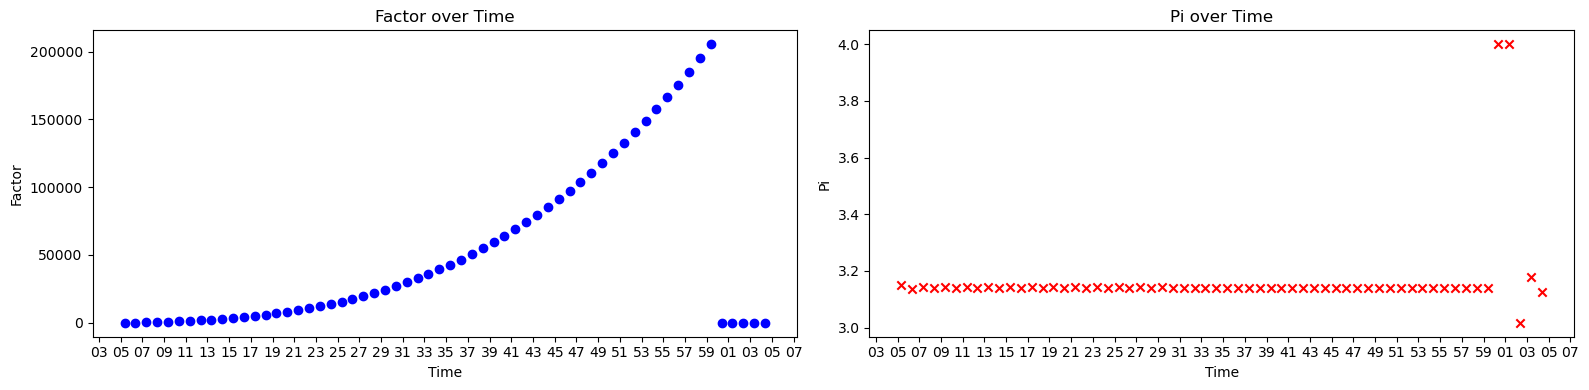

In [56]:
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, DateFormatter

print(df_full.head())
print(df_full.describe())
print(df_full.info())

date_form = DateFormatter("%M")

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.xaxis.set_major_locator(MinuteLocator(interval=2))
ax1.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_major_locator(MinuteLocator(interval=2))
ax2.xaxis.set_major_formatter(date_form)

ax1.scatter(df_full['Time'], df_full['Factor'], marker='o', color='blue')
ax2.scatter(df_full['Time'], df_full['Pi'], marker='x', color='red')

ax1.set_xlabel('Time')
ax1.set_ylabel('Factor')
ax1.set_title('Factor over Time')

ax2.set_xlabel('Time')
ax2.set_ylabel('Pi')
ax2.set_title('Pi over Time')

plt.tight_layout()
plt.show()

In [106]:
df_minute_only = df_full.copy()
df_minute_only['Time'] = df_minute_only['Time'].dt.minute
df_minute_only.head(1)

,primary_key,Time,Factor,Pi
0,0,5,125,3.149593


In [107]:
last_five = df_minute_only.tail(5)
df_minute_only = df_minute_only.drop(index=last_five.index)
df_minute_only = pd.concat([last_five, df_minute_only])
df_minute_only.reset_index(drop=True, inplace=True)
df_minute_only.head(6)

,primary_key,Time,Factor,Pi
0,55,0,1,4.000000
1,56,1,1,4.000000
2,57,2,8,3.017072
3,58,3,27,3.178617
4,59,4,64,3.125969
5,0,5,125,3.149593


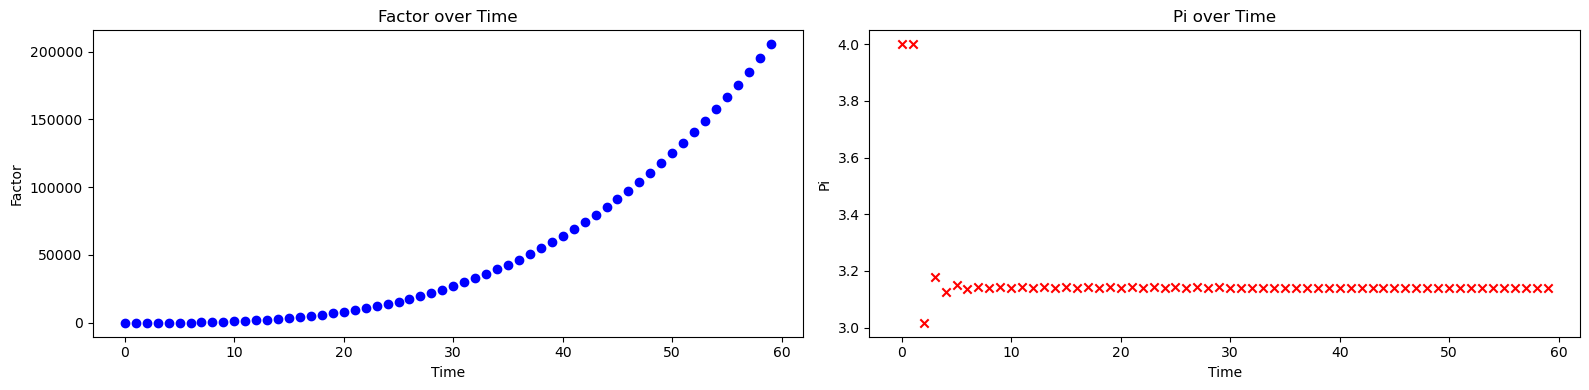

In [73]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.scatter(df_minute_only['Time'], df_minute_only['Factor'], marker='o', color='blue')
ax2.scatter(df_minute_only['Time'], df_minute_only['Pi'], marker='x', color='red')

ax1.set_xlabel('Time')
ax1.set_ylabel('Factor')
ax1.set_title('Factor over Time')

ax2.set_xlabel('Time')
ax2.set_ylabel('Pi')
ax2.set_title('Pi over Time')

plt.tight_layout()
plt.show()

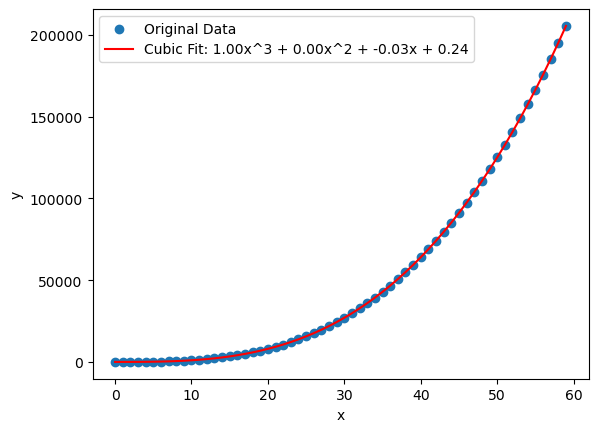

In [108]:
# Fit cubic regression model
coefficients = numpy.polyfit(df_minute_only['Time'], df_minute_only['Factor'], 3)
a, b, c, d = coefficients

fitted_values = a * df_minute_only['Time']**3 + b * df_minute_only['Time']**2 + c * df_minute_only['Time'] + d

plt.scatter(df_minute_only['Time'], df_minute_only['Factor'], label='Original Data')
plt.plot(df_minute_only['Time'], fitted_values, color='red', label=f'Cubic Fit: {a:.2f}x^3 + {b:.2f}x^2 + {c:.2f}x + {d:.2f}')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [110]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(fitted_values, df_minute_only['Factor'])
r_squared = r_value**2
print(f'R-squared: {r_squared:.4f}')

R-squared: 1.0000


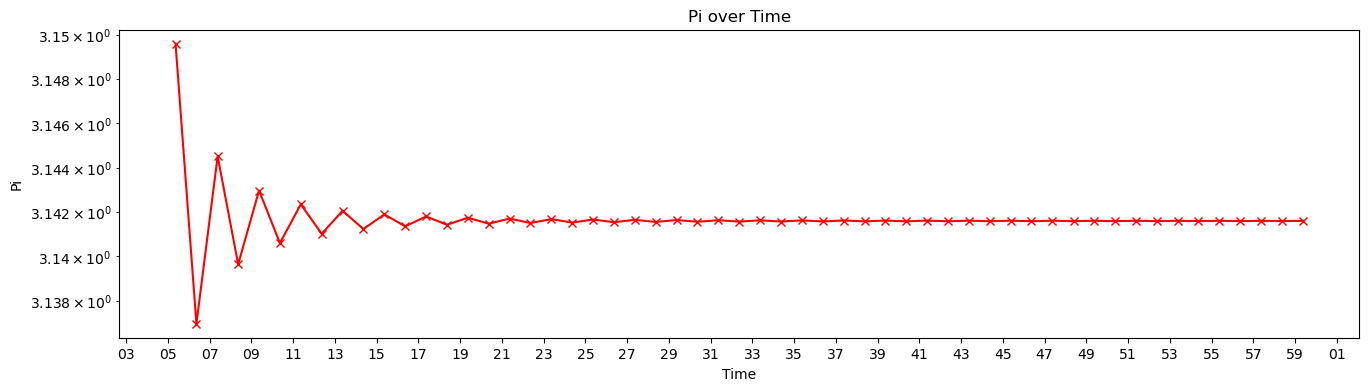

In [111]:
fig, ax = plt.subplots(figsize=(16, 4))

ax.xaxis.set_major_locator(MinuteLocator(interval=2))
ax.xaxis.set_major_formatter(date_form)

ax.semilogy(df_full['Time'][:55], df_full['Pi'][:55], marker='x', color='red')

ax.set_xlabel('Time')
ax.set_ylabel('Pi')
ax.set_title('Pi over Time')

plt.show()

In [115]:
import math

print(df_minute_only['Pi'].iloc[-1])
error_last = abs(math.pi - df_minute_only['Pi'].iloc[-1]) / abs(math.pi)
error_first = abs(math.pi - df_minute_only['Pi'].iloc[0]) / abs(math.pi)

print(f"Error using last point: {error_last}")
print(f"Error using first point: {error_first}")

3.141597522636734
Error using last point: 1.5498657775328784e-06
Error using first point: 0.2732395447351627
